In [1]:

import numpy as np
import matplotlib.pyplot as plt
import random as random
import math as math
from WeinerGeneratorNumba import getWeiner, getWeinerSubset, constructWeinerSubset
from tqdm.notebook import trange, tqdm
from numba import njit
from scipy.optimize import curve_fit

b = -0.05

t0 = 0
tend = 1
steps = 100000
dt = (tend-t0)/steps
h = 1.0
threshold = h/2
Kbar = 1.0

baseSteps = 1000000
Tend = 10
nRealizations = 100

def K(z):
    if z <= threshold:
        K = z*(h-2*z)*Kbar
    else:
        K = (h-z)*(-h+2*z)*Kbar
    return K
    
def dKdz(z):
    if z <= threshold:
        dKdz = h-4*z
    else:
        dKdz = 3*h-4*z
    return dKdz

def dgdz(z):
    #print(z)
    if z < threshold and z > 0:
        dgdz = math.sqrt(2) * (h - 4 * z) / (2 * math.sqrt(z * (h - 2 * z)))
    elif z > threshold and z < h:
        dgdz = math.sqrt(2) * (3 * h - 4 * z) / (2 * math.sqrt(-h**2 + 3 * h * z - 2 * z**2))
    else:
        dgdz = 0
    return dgdz

class Particle():
    def __init__(self, z):
        self.z = z

    
    def simulate(self, ts, dws, dt):
        """
        Optimized simulation using static simulateNumba
        """
        self.dt = dt
        self.ts = ts
        
        self.zs =self.simulateNumba(self.z, ts, dws, dt)

        return self.zs

    def simulatePython(self, ts, dws, dt):
        """
        Slow pure Python simulation
        """
        self.dt = dt
        self.ts = ts
        self.zs = []
        for index, t in enumerate(ts):
            #Story history
            self.zs.append(self.z)

            #Advance
            z0 = self.z
            z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            self.z = z1 

            #Correct if out of bounds
            self.correctBounds()
        return self.zs

    def correctBounds(self):
        if abs(self.z) > 2*h:
            print("Severe out of bounds")
            exit()
        if self.z < 0:
            self.z = - self.z
        if self.z > h:
            self.z = 2*h - self.z
        return

    @staticmethod
    @njit
    def simulateNumba(z, ts, dws, dt):
        #Optimized version using Numba (just in time compiler)
        zs = []
        for index, t in enumerate(ts):
            #Story history
            zs.append(z)
            z0 = z

            #calc K(z0)
            if z0 <= threshold:
                K = z0*(h-2*z0)*Kbar
            else:
                K = (h-z0)*(-h+2*z0)*Kbar

            #calc dKdz(z0)
            if z0 <= threshold:
                dKdz = h-4*z0
            else:
                dKdz = 3*h-4*z0

            #K = 1 #z0
            #dKdz = 0 #1

            #Advance
            z1 = z0 + dKdz*dt + math.sqrt(2*K)*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            z = z1 
        
            if abs(z) > 2*h:
                print("WARNING SEVERE OUT OF BOUNDS")
            if z < 0:
                z = -z
            if z > h:
                z = 2*h - z
        return zs

    def simulateMilstein(self, ts, dws, dt):
        """
        Optimized simulation using static simulateNumba
        """
        self.dt = dt
        self.ts = ts
        
        self.zs =self.simulateMilsteinNumba(self.z, ts, dws, dt)

        return self.zs

    @staticmethod
    @njit
    def simulateMilsteinNumba(z, ts, dws, dt):
        #Optimized version using Numba (just in time compiler)
        zs = []
        for index, t in enumerate(ts):
            #Story history
            zs.append(z)
            z0 = z

            #calc K(z0)
            if z0 <= threshold:
                K = z0*(h-2*z0)*Kbar
            else:
                K = (h-z0)*(-h+2*z0)*Kbar

            #calc dKdz(z0)
            if z0 <= threshold:
                dKdz = h-4*z0
            else:
                dKdz = 3*h-4*z0

            #calc dGdz
            if z0 < threshold and z0 > 0:
                dGdz = math.sqrt(2) * (h - 4 * z0) / (2 * math.sqrt(z0 * (h - 2 * z0)))
            elif z0 > threshold and z0 < h:
                dGdz = math.sqrt(2) * (3 * h - 4 * z0) / (2 * math.sqrt(-h**2 + 3 * h * z0 - 2 * z0**2))
            else:
                dGdz = 0

            #K = 1 #z0
            #dKdz = 0 #1

            #Advance
            z1 = z0 + dKdz * dt + math.sqrt(2 * K) * dws[index] + 0.5 * math.sqrt(2 * K) * dGdz * (dws[index]*dws[index] - dt) #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            z = z1 
        
            if abs(z) > 2*h:
                print("WARNING SEVERE OUT OF BOUNDS")
            if z < 0:
                z = -z
            if z > h:
                z = 2*h - z
                
        return zs


    def simulateMilsteinPython(self,ts,dws,dt):
        self.dt = dt
        self.ts = ts
        zs = []
        for index, t in enumerate(self.ts):
            zs.append(self.z)
            z0 = self.z
            # z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*random.gauss(0,1)*math.sqrt(dt)#*randomFactor # Euler
            z1 = z0 + dKdz(z0) * dt + math.sqrt(2 * K(z0)) * dws[index] + 0.5 * math.sqrt(2 * K(z0)) * dgdz(z0) * (dws[index]**2 - dt)
            
            #Store results
            self.z = z1 

            #Correct if out of bounds
            self.correctBounds()
        return zs

# Euler

## Strong

  0%|          | 0/99 [00:00<?, ?it/s]

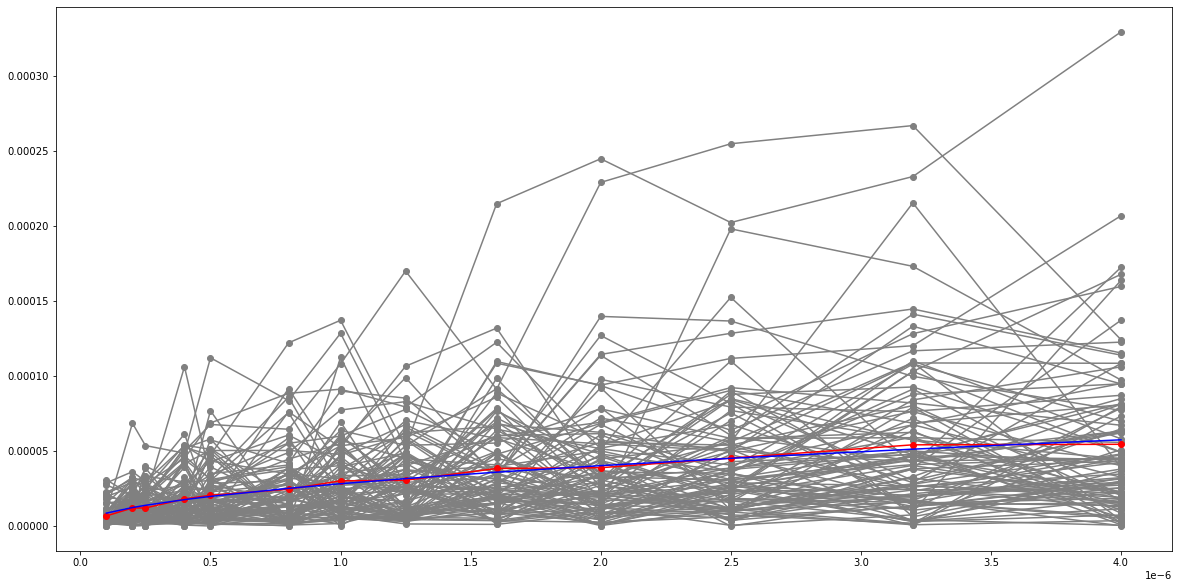

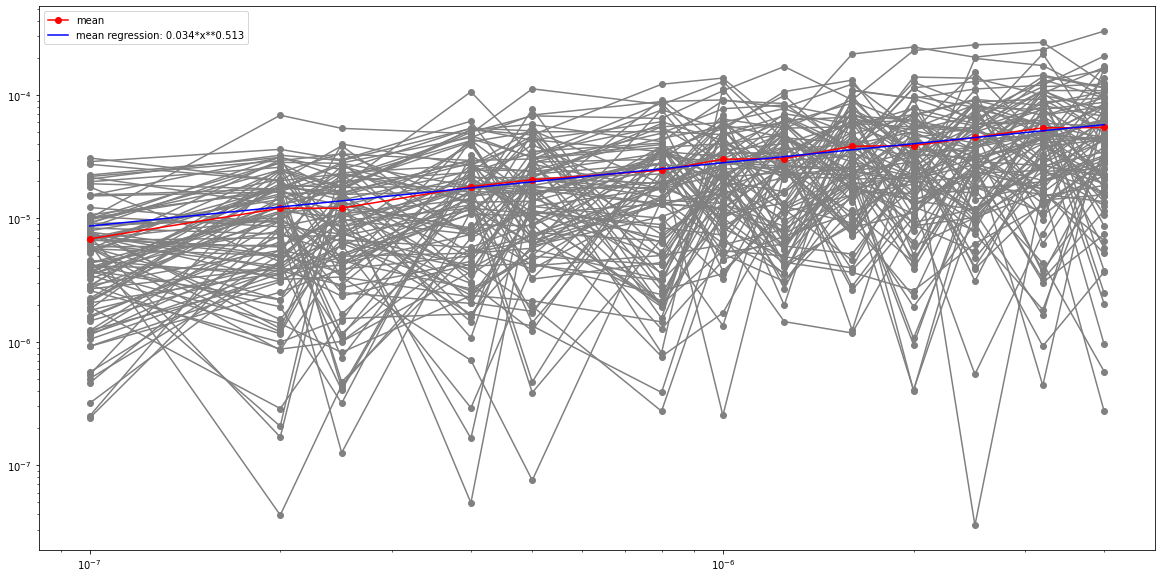

In [2]:
fig_linear = plt.figure(figsize=(20,10))
fig_log = plt.figure(figsize=(20,10))
ax1 = fig_linear.gca()
ax2 = fig_log.gca()

realizationDeltas = []

localBaseSteps = 10000000
localTend = 0.05

for realization in tqdm(np.arange(1,nRealizations)):
    iterlist = np.arange(1,100) #2000
    iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
    maxnth = iterlist[0]

    particles = []
    resolutions = []
   

    for i in iterlist:
        if baseSteps%i == 0:
            #print("readtime:")
            ts, ws, dws, dt = getWeinerSubset(i,baseSteps,localTend,realization)
            particle = Particle(0.25)
            #print("simulateMilstein time:")
            zs = particle.simulate(ts, dws, dt)
            particles.append(particle)

            #plt.plot(ts,zs, label = dt, color = (1-(maxnth-i)/maxnth, 0, 1-i/maxnth))
            resolutions.append(dt)

    #plt.legend(bbox_to_anchor=(1, 1))
    #plt.show()

    zeroParticle = particles[-1]  #Highest resolution track
    zeroZs = np.array(zeroParticle.zs)
    zeroTs = np.array(zeroParticle.ts)
    deltas = []

    coarserParticles = particles[:-1] #all particles except the reference one
    coarserResolutions = resolutions[:-1] #all resolutions except the reference one

    for particle in coarserParticles:
        zs = np.array(particle.zs)
        ts = np.array(particle.ts)
        delta = abs(zeroZs[-1] - zs[-1])
        deltas.append(delta)
        #plt.figure(figsize=(20,10))
        #plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
        #plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
        #plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
        #plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
        #plt.legend()
        #plt.title(f"dt = {particle.dt}")
    realizationDeltas.append(np.array(deltas))
    
    ax1.plot(coarserResolutions, deltas, color = "grey", marker = "o")
    ax2.loglog(coarserResolutions, deltas, color = "grey", marker = "o")

realizationDeltasMean = np.mean(np.array(realizationDeltas), axis = 0) #construct array of len(deltas) that contains the average of all realizationDeltas at every point (expectation as n goes to infinity)

def power(x,a,b):
    return a * np.power(x, b)
popt, pcov = curve_fit(power, coarserResolutions, realizationDeltasMean)

ax1.plot(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
ax1.plot(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
ax2.loglog(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
ax2.loglog(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
plt.legend()

## Weak (Identical Wiener)

In [2]:
localBaseSteps = 100000
localTend = 0.05
localNRealizations = 2500

In [ ]:
iterlist = np.arange(1,2000)
maxnth = iterlist[-1]

realizationDeltas = []

nths = []
for i in iterlist:
    if localBaseSteps%i == 0:
        nths.append(i)

#realizationDatas = []
for realization in np.arange(1,localNRealizations):
    baseTs, baseWs, baseDws, baseDt = getWeiner(localBaseSteps, localTend, realization, noIO = True)
    realizationData = {'baseTs': baseTs, 'baseWs': baseWs,'baseDws': baseDws,'baseDt': baseDt}
    #realizationDatas.append(realizationData)
    with open(f"Storage/realization{realization}.pkl", 'wb') as f:
        pickle.dump(realizationData, f)

  0%|          | 0/24 [00:00<?, ?it/s]

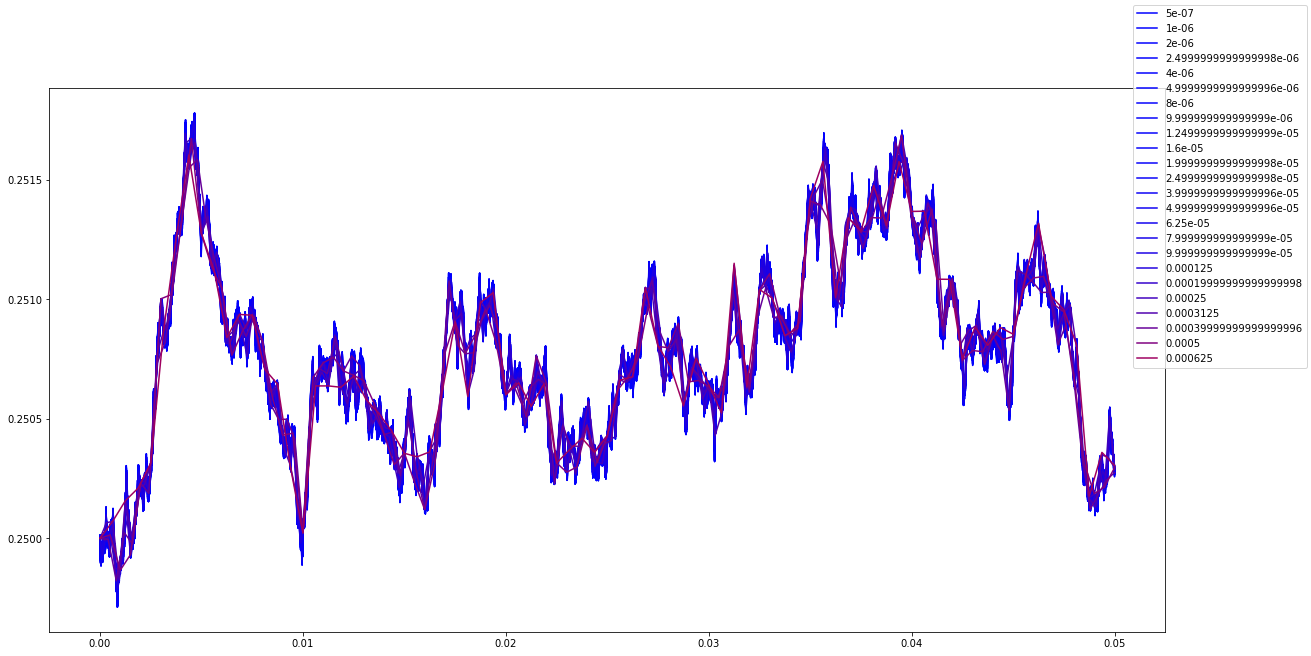

In [3]:
import pickle

#fig_all = plt.figure(figsize=(20,10))
fig_mean = plt.figure(figsize=(20,10))
#fig_single = plt.figure(figsize=(20,10))
#ax1 = fig_all.gca()
ax2 = fig_mean.gca()
#ax3 = fig_single.gca()


pseudoParticles = []
resolutions = []
for nth in tqdm(nths):
    zss = []
    
    for realization in np.arange(1,localNRealizations):
        with open(f"Storage/realization{realization}.pkl", 'rb') as f:
            realizationData = pickle.load(f)

        ts, ws, dws, dt = constructWeinerSubset(
            nth, 
            realizationData['baseTs'], 
            realizationData['baseWs'], 
            realizationData['baseDws'], 
            realizationData['baseDt']
        )

        particle = Particle(0.25)
        zs = particle.simulate(ts, dws, dt)
        zss.append(np.array(zs))

        #ax1.plot(ts,zs, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))

        #if nth == 1:
           #ax3.plot(ts,zs, label = dt, color = "grey")

    zssMean = np.mean(np.array(zss), axis = 0)
    ax2.plot(ts, zssMean, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))
    #if nth == 1:
    #    ax3.plot(ts,zssMean, label = dt, color = "red")

    pseudoParticle = Particle(0)
    pseudoParticle.zs = zssMean
    pseudoParticle.ts = ts
    pseudoParticle.dt = dt
    pseudoParticles.append(pseudoParticle)
    resolutions.append(dt)

#fig_single.legend(loc = "upper right")
#fig_all.legend(loc = "upper right")
fig_mean.legend(loc = "upper right")

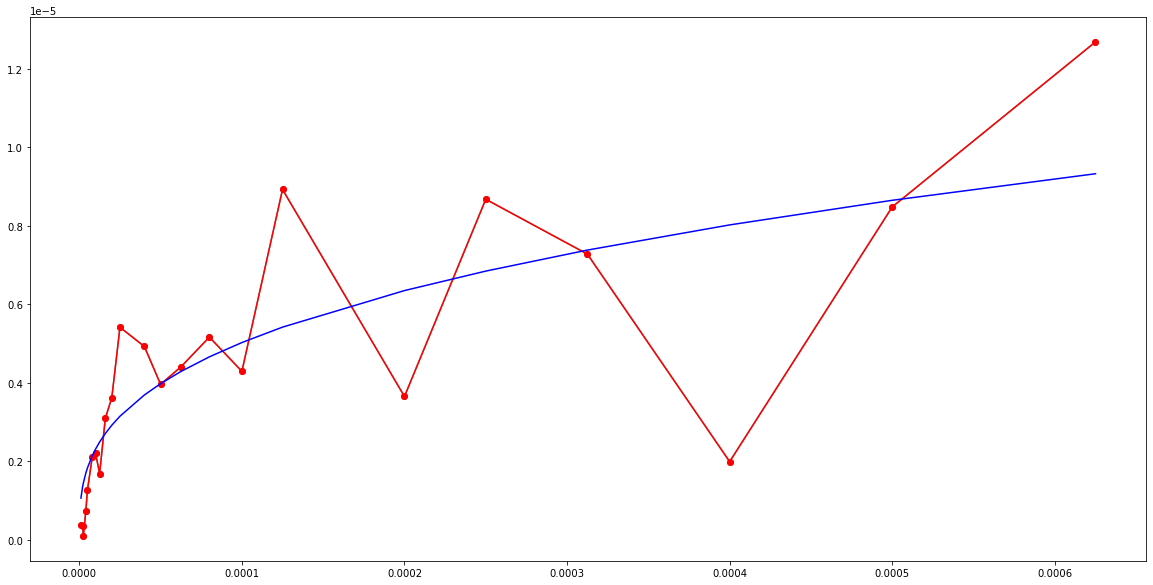

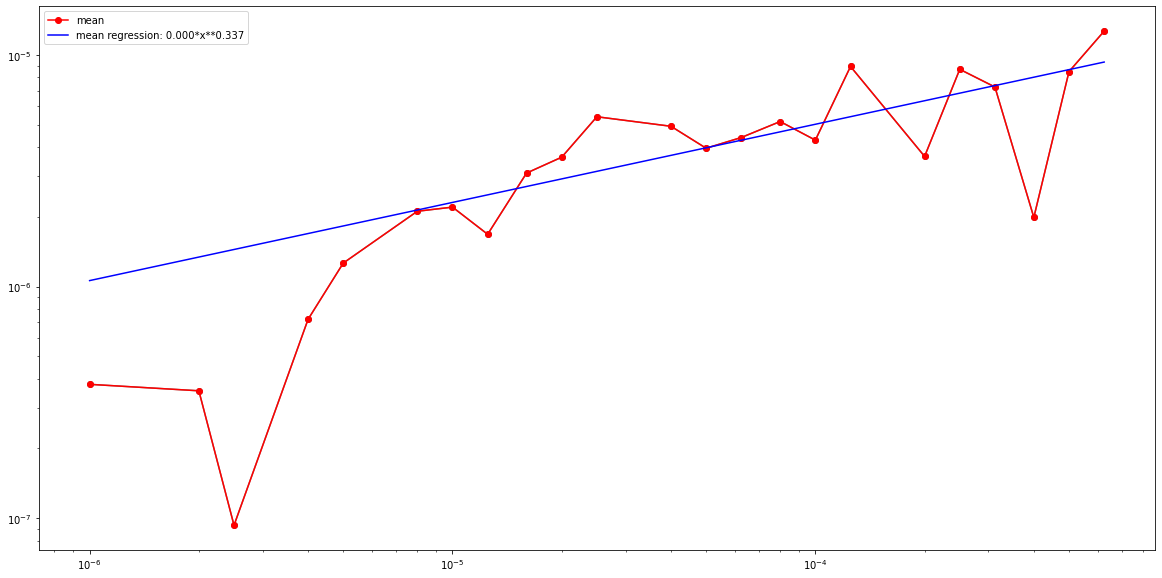

In [4]:
fig_linear = plt.figure(figsize=(20,10))
fig_log = plt.figure(figsize=(20,10))
ax1 = fig_linear.gca()
ax2 = fig_log.gca()

zeroParticle = pseudoParticles[0]  #Highest resolution track
zeroZs = np.array(zeroParticle.zs)
zeroTs = np.array(zeroParticle.ts)
deltas = []

coarserParticles = pseudoParticles[1:] #all particles except the reference one
coarserResolutions = resolutions[1:] #all resolutions except the reference one

#realizationDeltas = []

for particle in coarserParticles:
    zs = np.array(particle.zs)
    ts = np.array(particle.ts)
    zs_interpolated = np.interp(zeroTs, ts, zs)
    delta = abs(zeroZs[-1]**2 - zs[-1]**2)
    deltas.append(delta)
    #plt.figure(figsize=(20,10))
    #plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
    #plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
    #plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
    #plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
    #plt.legend()
    #plt.title(f"dt = {particle.dt}")
##realizationDeltas.append(np.array(deltas))

ax1.plot(coarserResolutions, deltas, color = "grey", marker = "o")
ax2.loglog(coarserResolutions, deltas, color = "grey", marker = "o")

#realizationDeltasMean = np.mean(np.array(realizationDeltas), axis = 0) #construct array of len(deltas) that contains the average of all realizationDeltas at every point (expectation as n goes to infinity)

def power(x,a,b):
    return a * np.power(x, b)
popt, pcov = curve_fit(power, coarserResolutions, deltas)

ax1.plot(coarserResolutions, deltas, marker = "o", color = "red", label = "mean")
ax1.plot(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
ax2.loglog(coarserResolutions, deltas, marker = "o", color = "red", label = "mean")
ax2.loglog(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
plt.legend()

## Weak (Different Wiener)

In [2]:
localBaseSteps = 100000
localTend = 0.05
localNRealizations = 2500

In [3]:
def getStepsList(depth):
    iterlist = np.arange(1,depth)
    maxSteps = iterlist[-1]

    realizationDeltas = []

    stepsList = []
    for i in iterlist:
        if localBaseSteps%i == 0:
            stepsList.append(int(localBaseSteps/i))

    return stepsList, maxSteps

In [ ]:
def GetEulerRealization(steps, tend, realization, noIO = False):
    ts, ws, dws, dt = getWeiner(steps, tend, realization, noIO = False)

    particle = Particle(0.25)
    zs = particle.simulate(ts, dws, dt)
    return ts, zs

  0%|          | 0/24 [00:00<?, ?it/s]

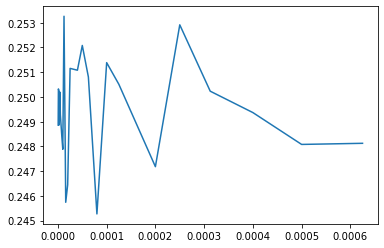

In [7]:
def getExpectedEndPoints(depth):
    stepsList, maxSteps = getStepsList(depth)

    expectedEndPoints = []
    resolutions = []
    for steps in tqdm(stepsList): #Iterate over resolutions (calc expectation of endpoints)
        endpoints = []
        for realization in np.arange(1,localNRealizations):
            zs = GetEulerRealization(steps, localTend, realization, noIO=True)
            endpoints.append(zs[-1])
        
        resolutions.append(dt)
        meanEndPoint = np.mean(endpoints)
        expectedEndPoints.append(meanEndPoint)

    return resolutions, expectedEndPoints

def plotError(depth):
    resolutions, expectedEndPoints = getExpectedEndPoints(depth)
    plt.plot(resolutions, expectedEndPoints)

plotError(2000)
        


# Milstein

## Strong

In [ ]:
localBaseSteps = 100000
localTend = 0.05
localNRealizations = 2500

In [ ]:
fig_linear = plt.figure(figsize=(20,10))
fig_log = plt.figure(figsize=(20,10))
ax1 = fig_linear.gca()
ax2 = fig_log.gca()

realizationDeltas = []

localBaseSteps = 10000000
localTend = 0.5

for realization in tqdm(np.arange(1,nRealizations)):
    iterlist = np.arange(1,500) #2000
    iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
    maxnth = iterlist[0]

    particles = []
    resolutions = []
   

    for i in iterlist:
        if baseSteps%i == 0:
            #print("readtime:")
            ts, ws, dws, dt = getWeinerSubset(i,baseSteps,Tend,realization)
            particle = Particle(0.25)
            #print("simulateMilstein time:")
            zs = particle.simulateMilstein(ts, dws, dt)
            particles.append(particle)

            #plt.plot(ts,zs, label = dt, color = (1-(maxnth-i)/maxnth, 0, 1-i/maxnth))
            resolutions.append(dt)

    #plt.legend(bbox_to_anchor=(1, 1))
    #plt.show()

    zeroParticle = particles[-1]  #Highest resolution track
    zeroZs = np.array(zeroParticle.zs)
    zeroTs = np.array(zeroParticle.ts)
    deltas = []

    coarserParticles = particles[:-1] #all particles except the reference one
    coarserResolutions = resolutions[:-1] #all resolutions except the reference one

    for particle in coarserParticles:
        zs = np.array(particle.zs)
        ts = np.array(particle.ts)
        delta = abs(zeroZs[-1] - zs[-1])
        deltas.append(delta)
        #plt.figure(figsize=(20,10))
        #plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
        #plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
        #plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
        #plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
        #plt.legend()
        #plt.title(f"dt = {particle.dt}")
    realizationDeltas.append(np.array(deltas))
    
    ax1.plot(coarserResolutions, deltas, color = "grey", marker = "o")
    ax2.loglog(coarserResolutions, deltas, color = "grey", marker = "o")

realizationDeltasMean = np.mean(np.array(realizationDeltas), axis = 0) #construct array of len(deltas) that contains the average of all realizationDeltas at every point (expectation as n goes to infinity)

def power(x,a,b):
    return a * np.power(x, b)
popt, pcov = curve_fit(power, coarserResolutions, realizationDeltasMean)

ax1.plot(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
ax1.plot(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
ax2.loglog(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
ax2.loglog(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
plt.legend()

## Weak

In [ ]:
localBaseSteps = 100000
localTend = 0.05
localNRealizations = 2500

In [ ]:
fig_linear = plt.figure(figsize=(20,10))
fig_log = plt.figure(figsize=(20,10))
ax1 = fig_linear.gca()
ax2 = fig_log.gca()

realizationDeltas = []

localBaseSteps = 10000000
localTend = 0.05

for realization in tqdm(np.arange(1,nRealizations)):
    iterlist = np.arange(1,100) #2000
    iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
    maxnth = iterlist[0]

    particles = []
    resolutions = []
   

    for i in iterlist:
        if baseSteps%i == 0:
            #print("readtime:")
            ts, ws, dws, dt = getWeinerSubset(i,baseSteps,localTend,realization)
            particle = Particle(0.25)
            #print("simulateMilstein time:")
            zs = particle.simulate(ts, dws, dt)
            particles.append(particle)

            #plt.plot(ts,zs, label = dt, color = (1-(maxnth-i)/maxnth, 0, 1-i/maxnth))
            resolutions.append(dt)

    #plt.legend(bbox_to_anchor=(1, 1))
    #plt.show()

    zeroParticle = particles[-1]  #Highest resolution track
    zeroZs = np.array(zeroParticle.zs)
    zeroTs = np.array(zeroParticle.ts)
    deltas = []

    coarserParticles = particles[:-1] #all particles except the reference one
    coarserResolutions = resolutions[:-1] #all resolutions except the reference one

    for particle in coarserParticles:
        zs = np.array(particle.zs)
        ts = np.array(particle.ts)
        delta = abs(zeroZs[-1] - zs[-1])
        deltas.append(delta)
        #plt.figure(figsize=(20,10))
        #plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
        #plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
        #plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
        #plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
        #plt.legend()
        #plt.title(f"dt = {particle.dt}")
    realizationDeltas.append(np.array(deltas))
    
    ax1.plot(coarserResolutions, deltas, color = "grey", marker = "o")
    ax2.loglog(coarserResolutions, deltas, color = "grey", marker = "o")

realizationDeltasMean = np.mean(np.array(realizationDeltas), axis = 0) #construct array of len(deltas) that contains the average of all realizationDeltas at every point (expectation as n goes to infinity)

def power(x,a,b):
    return a * np.power(x, b)
popt, pcov = curve_fit(power, coarserResolutions, realizationDeltasMean)

ax1.plot(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
ax1.plot(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
ax2.loglog(coarserResolutions, realizationDeltasMean, marker = "o", color = "red", label = "mean")
ax2.loglog(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
plt.legend()